In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *
from docking_analysis import *

Couldn't import dot_parser, loading of dot files will not be possible.


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
%matplotlib inline

In [3]:
from detect_intermediates import *
from interpret_tICs import *

we are operating on biox3


In [4]:
from mor_h8_protein_ligand_feature_types import *
from get_variable_names import *
from mor_h8_protein_ligand_tica_config import *
from residue import Residue, Atom
from mor_h8_feature_types import feature_name_residues_dict


[65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,

In [5]:
#feature_name = "bp_residues_4dkl_5c1m_restricted_pairs"
rho = 0.01
rho_string = "_rho0pt01-normalized"

feature_name = "bp_residues_4dkl_5c1m_restricted_pairs_10A"
#rho = 0.0025
#rho_string = "_rho0pt0025-normalized"

lag_time=5
n_clusters=1000
n_components=10

In [6]:
feature_name

'bp_residues_4dkl_5c1m_restricted_pairs_10A'

In [7]:
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
ori_tica_dir = copy.deepcopy(tica_dir)
tica_dir = "%s_OXY" %tica_dir

features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A
/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A


In [19]:
ligand_residue = Residue(resSeq=1, chain_id="L", res_name="LIG")

In [20]:
active_crystal = md.load_frame([t for t in get_trajectory_files(traj_dir, traj_ext) if "oxy" in t][0], index=0)
ligand = [r for r in active_crystal.topology.residues if "LIG" in str(r)][0]
ligand_atom_names = [a.name for a in ligand.atoms if "H" not in a.name and "C" not in a.name]
print(ligand_atom_names)

[u'S1', u'O2', u'O3', u'N4', u'N5']


In [25]:
#ligand_atom_names = ["N1", "O1", "C7", "C17", "O2", "N2", "C26"]
ligand_atoms = []
for atom_name in ligand_atom_names:
    ligand_atoms.append(Atom(resSeq=1, chain_id="L", atom_name=atom_name, res_name="LIG"))

In [26]:
ligand_atoms

[LIG-S1, LIG-O2, LIG-O3, LIG-N4, LIG-N5]

In [27]:
user_specified_atom_residue_pairs = [x for x in itertools.product(ligand_atoms, bp_residue_objects)]


In [28]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
protein_file = "/home/enf/md_simulations/MOR/Active_OXY_neworientation_noNanobody/ionized.pdb"
refined_atom_residue_pairs = compute_atom_residue_pairs_under_cutoff(ligand_atoms, bp_residue_objects, protein_file, cutoff=1., all_lig_atoms=True)

In [29]:
refined_atom_residue_pairs

[(LIG-S1, TRP293),
 (LIG-S1, PRO295),
 (LIG-S1, ILE296),
 (LIG-S1, HIS297),
 (LIG-S1, ILE298),
 (LIG-S1, TYR299),
 (LIG-S1, VAL300),
 (LIG-S1, ILE301),
 (LIG-S1, TRP318),
 (LIG-S1, CYS321),
 (LIG-S1, ILE322),
 (LIG-S1, GLY325),
 (LIG-S1, TYR326),
 (LIG-S1, PHE239),
 (LIG-S1, ALA240),
 (LIG-S1, ILE238),
 (LIG-S1, LEU219),
 (LIG-S1, LYS233),
 (LIG-S1, ILE234),
 (LIG-S1, LEU232),
 (LIG-S1, VAL202),
 (LIG-S1, PHE241),
 (LIG-S1, VAL236),
 (LIG-S1, PHE237),
 (LIG-S1, CYS235),
 (LIG-S1, ASN150),
 (LIG-S1, MET151),
 (LIG-S1, PHE152),
 (LIG-S1, ILE155),
 (LIG-S1, ILE144),
 (LIG-S1, ASP147),
 (LIG-S1, TYR148),
 (LIG-S1, TYR149),
 (LIG-S1, GLN124),
 (LIG-S1, ILE198),
 (LIG-O2, ILE322),
 (LIG-O2, TYR326),
 (LIG-O2, ASP216),
 (LIG-O2, THR218),
 (LIG-O2, LEU219),
 (LIG-O2, CYS217),
 (LIG-O2, ALA206),
 (LIG-O2, VAL202),
 (LIG-O2, LEU139),
 (LIG-O2, CYS140),
 (LIG-O2, LYS141),
 (LIG-O2, ILE142),
 (LIG-O2, VAL143),
 (LIG-O2, ILE144),
 (LIG-O2, SER145),
 (LIG-O2, ILE146),
 (LIG-O2, ASP147),
 (LIG-O2, TY

In [13]:
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

243


<AsyncMapResult: chdir>

In [14]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *

In [16]:
len(refined_atom_residue_pairs)

1023

In [18]:
if not os.path.exists(features_dir): os.makedirs(features_dir)
featurize_contacts_custom(traj_dir, features_dir = features_dir, traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, structures=[], contact_residues=[],
                          residues_map = None, contact_cutoff = cutoff, parallel = True, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs=refined_atom_residue_pairs, worker_pool=dview, excluded_trajs=["apo", "oxy"])

There are 1023 contact pairs to be used in contact featurization.
Saving contact feature residue pairs to disk.
About to featurize trajectories based on the chosen featurization scheme.
[]


CompositeError: one or more exceptions from call to method: <functools.partial object at 0x7fdac13f1ec0>
[Engine Exception]IndexError: list index out of range
[Engine Exception]IndexError: list index out of range
[Engine Exception]IndexError: list index out of range
[Engine Exception]IndexError: list index out of range
.... 77 more exceptions ...

In [16]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
new_features_dir = "%s/reduced_features" %features_dir
if not os.path.exists(new_features_dir):
    os.makedirs(new_features_dir)
new_features_file = "%s/reduced_features.dataset" %new_features_dir
new_features_pkl = "%s/reduced_feature_names.pkl" %new_features_dir
#retain_features_within_range(features_dir, feature_residues_pkl, 0.6,
#                             0.1, new_features_file, new_features_pkl, worker_pool=dview)

In [17]:
with open(new_features_pkl) as f:
    new_feature_names = pickle.load(f)
print(new_feature_names)
print(len(new_feature_names))

[(Lig900-C6, Trp293), (Lig900-C6, Ile296), (Lig900-C6, His297), (Lig900-C6, Val300), (Lig900-C6, Ile322), (Lig900-C6, Gly325), (Lig900-C6, Tyr326), (Lig900-C6, Val236), (Lig900-C6, Tyr148), (Lig900-C6, Met151), (Lig900-C6, Asp147), (Lig900-C7, Trp293), (Lig900-C7, Ile296), (Lig900-C7, His297), (Lig900-C7, Val300), (Lig900-C7, Gly325), (Lig900-C7, Tyr326), (Lig900-C7, Ala240), (Lig900-C7, Val236), (Lig900-C7, Tyr148), (Lig900-C7, Met151), (Lig900-C8, Trp293), (Lig900-C8, Ile296), (Lig900-C8, His297), (Lig900-C8, Val300), (Lig900-C8, Trp318), (Lig900-C8, Gly325), (Lig900-C8, Ala240), (Lig900-C8, Val236), (Lig900-C8, Lys233), (Lig900-C8, Tyr148), (Lig900-C8, Met151), (Lig900-C9, Trp293), (Lig900-C9, Ile296), (Lig900-C9, His297), (Lig900-C9, Val300), (Lig900-C9, Trp318), (Lig900-C9, Ala240), (Lig900-C9, Val236), (Lig900-C9, Lys233), (Lig900-C9, Tyr148), (Lig900-C9, Met151), (Lig900-C10, Trp293), (Lig900-C10, Ile296), (Lig900-C10, His297), (Lig900-C10, Val300), (Lig900-C10, Trp318), (Lig900

In [40]:
ref_receptors_dir = "/home/enf/md_simulations/MOR/bu72_ref_receptors" 
ref_features_dir = "%s/bu72_ref_receptors" %features_dir
featurize_contacts_custom(ref_receptors_dir, features_dir = ref_features_dir, traj_ext = ".pdb", contact_residue_pairs_file = feature_residues_pkl, structures=[], contact_residues=[],
                          residues_map = None, contact_cutoff = cutoff, parallel = True, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs = new_feature_names, worker_pool=None, schemes=[])

already featurized
already featurized


IndexError: list index out of range

In [18]:
import pickle
with open(new_features_pkl, "rb") as f:
    feature_residues = pickle.load(f)

In [21]:
feature_residues[:10]

[(Lig900-C6, Trp293),
 (Lig900-C6, Ile296),
 (Lig900-C6, His297),
 (Lig900-C6, Val300),
 (Lig900-C6, Ile322),
 (Lig900-C6, Gly325),
 (Lig900-C6, Tyr326),
 (Lig900-C6, Val236),
 (Lig900-C6, Tyr148),
 (Lig900-C6, Met151)]

In [103]:
#os.system("rm -rf %s" % tica_dir)
#lag_time = 5
#n_components = 5
#sparse = True
#wolf = True
#rho = 0.0025
#shrinkage = None
#traj_ext = ".h5"
import custom_tica
reload(custom_tica)
from custom_tica import *
#fit_normalizer(features_dir, features=load_file(new_features_file))
fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True, partial_fit=False, features=load_file(new_features_file))

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/reduced_features/reduced_features.dataset
loading "/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/normalizer.h5"...
loading feature files
(553, 286)
[ 0.63818729  0.56125003  0.56126994  0.50798243  0.83793563  1.05688596
  1.02812457  0.57149577  0.61330134  0.424909  ]
(512,)
fitting data to tICA model
transformed data with tICA model
Sparse time-structure based Independent Components Analysis (tICA)
------------------------------------------------------------------
n_components        : 10
shrinkage           : 3.27425399002e-05
lag_time            : 5
weighted_transform  : False
rho                 : 0.01
n_features          : 286

Top 5 timescales :
[ 225.51623868  132.71137765  130.47015508   94.94842524   59.63714483]

Top 5 eigenvalues :
[ 0.97807263  0.96302516  0.96240209  0.94870236  0.91957804]

Number of active degrees of freedom:

In [108]:
import custom_tica
reload(custom_tica)
from custom_tica import *
if not os.path.exists(ref_features_dir):
    os.makedirs(ref_features_dir)
transform(existing_model = projection_operator_dir, features_directory = ref_features_dir, tica_dir = ref_tica_dir, normalizer=verboseload("%s/normalizer.h5" %features_dir))

loading "/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/normalizer.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized/phi_psi_chi2_allprot_tica_coords.h5"...
None
None
['/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/bu72_ref_receptors/bu72_aligned_4DKL_R_L.dataset', '/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/bu72_ref_receptors/bu72_ionized_pymol_RL.dataset']
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/bu72_ref_receptors/bu72_aligned_4DKL_R_L.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/bu72_ref_receptors/bu72_ionized_pymol_RL.dataset


In [19]:
tica_object = verboseload(projection_operator_dir)
tica_object.timescales_

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized/phi_psi_chi2_allprot_tica_coords.h5"...


array([ 225.51623868,  132.71137765,  130.47015508,   94.94842524,
         59.63714483,   50.37716614,   34.21799198,   34.17849676,
         31.34196636,   23.01265718])

In [20]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
tic_components_dir = tica_dir
important_contact_features, all_tIC_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, new_features_pkl, n_tica_components=n_components, percentile=95)

Interpreting tIC 1
feature_importances_df.shape
(6, 7)
residue_importances_df.shape
(8, 3)
        feature_name       res_i   res_j  resid_i  resid_j  importance  \
4  Lig900-C27-Val143  Lig900-C27  Val143      900      143   -0.793100   
2  Lig900-C24-Asp147  Lig900-C24  Asp147      900      147    0.715314   
3  Lig900-C26-Val143  Lig900-C26  Val143      900      143    0.602285   
0  Lig900-C23-Asp147  Lig900-C23  Asp147      900      147   -0.516993   
1  Lig900-C24-Trp133  Lig900-C24  Trp133      900      133    0.444762   
5  Lig900-C28-Trp133  Lig900-C28  Trp133      900      133   -0.435072   

                feature  
4  (Lig900-C27, Val143)  
2  (Lig900-C24, Asp147)  
3  (Lig900-C26, Val143)  
0  (Lig900-C23, Asp147)  
1  (Lig900-C24, Trp133)  
5  (Lig900-C28, Trp133)  
Using dark_background
               residue  importance  resid
Lig900-C27  Lig900-C27   -0.793100    900
Lig900-C24  Lig900-C24    0.701787    900
Asp147          Asp147    0.653699    147
Lig900-C26  Lig900

In [21]:
tic_subsampled_features_file= "%s/features_subsampled.pkl" % tica_dir



In [22]:
len(feature_residues)

286

In [23]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

print tic_subsampled_features_file
subsampled_features_dir = os.path.join(tica_dir, "subsampled_features")
if not os.path.exists(subsampled_features_dir): os.makedirs(subsampled_features_dir)
important_contact_features_pruned, important_contact_features_indices = find_non_zero_features(important_contact_features, feature_residues)
#subsample_features(features_dir, important_contact_features_indices, important_contact_features_pruned, tic_subsampled_features_file, features=load_file(new_features_file))

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized/features_subsampled.pkl


In [24]:
tica_coords = verboseload(projected_features_dir)
print(np.shape(np.concatenate(tica_coords)))

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized/phi_psi_chi2_allprot_projected.h5"...
(245952, 10)


In [24]:
import analysis
reload(analysis)
from analysis import *
plot_columns(tica_dir, projected_features_dir, titles = ["BU72_tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10bp_residues_4dkl_5c1m_restricted_pairs_5A_regularization_wolf_autoShrinkage_rho0pt1-normalized/phi_psi_chi2_allprot_projected.h5"...
()
None
Done plotting columns


In [25]:
bu72_trajs = []
apo_trajs = []
#trajs = [t for t in get_trajectory_files(traj_dir, traj_ext) if "apo_reimaged" not in t and "oxy" not in t]
trajs = [t for t in get_trajectory_files(traj_dir, traj_ext)]
for i, traj in enumerate(trajs):
    if "bu72" in traj:
        bu72_trajs.append(i)
    elif "apo" in traj and "reimaged" not in traj:
        apo_trajs.append(i)

user_defined_coords = load_file(user_defined_features_file)

            

loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5"...


In [26]:
#pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025"
pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05/"

In [27]:
protein_tica_file = "%s/phi_psi_chi2_allprot_projected.h5" %pp_tica_dir
protein_tica = verboseload(protein_tica_file)
protein_tica_bu72 = [protein_tica[i] for i in bu72_trajs]

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05//phi_psi_chi2_allprot_projected.h5"...


In [28]:
len(bu72_trajs)

512

In [29]:
protein_tica_bu72_conc = np.concatenate(protein_tica_bu72)
ligand_tica_bu72_conc =  np.concatenate(verboseload(projected_features_dir))

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized/phi_psi_chi2_allprot_projected.h5"...


In [30]:
import plots
reload(plots)
from plots import *

#plot_data_vs_data(protein_tica_bu72_conc, ligand_tica_bu72_conc, ["mOR_tIC%d" %i for i in range(1,n_components+1)], ["BU72_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)

In [31]:
n_clusters = 1000
clusterer_dir = "%s/bu72clusterer_%dclusters.h5" % (tica_dir, n_clusters)
cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters, clusterer_dir)

loading /home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized/phi_psi_chi2_allprot_projected.h5
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized/bu72clusterer_1000clusters.h5"...
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized/bu72clusterer_1000clusters.h5"... (<class 'msmbuilder.cluster.MiniBatchKMeans'>)


In [32]:
def calculate_cluster_averages_per_feature(clusterer, features):
  n_clusters = clusterer.n_clusters 
  concatenated_clusters = np.concatenate(clusterer.labels_)
  concatenated_features = np.concatenate(features)
  cluster_averages = np.zeros((n_clusters, concatenated_features.shape[1]))
  for i in range(0, n_clusters):
    rows = np.where(concatenated_clusters == i)[0]
    means = np.mean(concatenated_features[rows,:], axis=0)
    cluster_averages[i,:] = means
  return cluster_averages

In [ ]:
import custom_msm
reload(custom_msm)
from custom_msm import *
plot_timescales(clusterer_dir, n_clusters, tica_dir, main="", lag_times=list(range(1,51,10)))

In [33]:
lag_time = 30
msm_model_dir = "%s/msm_lag_time%d.h5" % (tica_dir, lag_time)
if not os.path.exists(msm_model_dir):
    build_msm(clusterer_dir, lag_time=lag_time, msm_model_dir=msm_model_dir)

In [34]:
import msmbuilder 
reload(msmbuilder)
import msm_resampled
reload(msm_resampled)
from msm_resampled import *

In [35]:
'%s/bu72_clusterer1000.h5' %pp_tica_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05//bu72_clusterer1000.h5'

In [36]:
pp_msm_lag_time=25
bu72_pp_resampled_traj_to_frames_file = "%s/bu72_msm_lag-time%d_prior-counts0.0_clusters1000_resampled_10000.h5" %(pp_tica_dir, pp_msm_lag_time)
bu72_pp_resampled_traj_to_frames = verboseload(bu72_pp_resampled_traj_to_frames_file)
bu72_pp_msm_file = "%s/bu72_msm_lag-time%d_prior-counts0.0_clusters1000.h5" %(pp_tica_dir, pp_msm_lag_time)
bu72_pp_msm = verboseload(bu72_pp_msm_file)
bu72_pp_clusterer = verboseload('%s/bu72_clusterer1000.h5' %pp_tica_dir)
bu72_pp_clusters_map = make_clusters_map(bu72_pp_clusterer)
bu72_pp_projection_operator_dir = "%s/phi_psi_chi2_allprot_tica_coords.h5" %pp_tica_dir
bu72_pp_tic_components_dir = "%s" %pp_tica_dir
bu72_pp_tica_dir = bu72_pp_tic_components_dir
bu72_pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/feature_residues.pkl"
bu72_pp_tic_subsampled_features = "%s/features_subsampled.pkl" %pp_tica_dir
bu72_pp_tica = verboseload("%s/bu72_tica_msm_lag-time%d_prior-counts0.0_clusters1000_resampled_10000.h5" %(pp_tica_dir, pp_msm_lag_time))
bu72_pp_pnas_file = "%s/bu72_pnas_msm_lag-time%d_prior-counts0.0_clusters1000_resampled_10000.h5" %(pp_tica_dir, pp_msm_lag_time)
bu72_pp_pnas = verboseload(bu72_pp_pnas_file)
bu72_pp_ref_tica = "%s/reference_receptors/refcoords.csv" %pp_tica_dir
bu72_pp_ref_features_dir = '/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors'

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05//bu72_msm_lag-time25_prior-counts0.0_clusters1000_resampled_10000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05//bu72_msm_lag-time25_prior-counts0.0_clusters1000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05//bu72_clusterer1000.h5"...
600
204
230
623
3
0
414
278
112
570
0
740
162
498
76
68
492
455
1126
228
394
396
0
72
44
392
4
378
229
0
31
110
4
6
487
686
516
34
115
803
428
345
216
97
218
201
118
322
1
163
0
323
180
132
467
245
0
154
31
199
586
146
197
1066
377
0
464
405
0
331
754
325
73
564
730
821
20
741
174
687
38
18
0
288
100
225
199
907
164
607
665
0
532
7
0
66
321
571
233
360
0
191
104
0

In [37]:
pp_msm_lag_time=25
apo_pp_resampled_traj_to_frames_file = "%s/apo_msm_lag-time%d_prior-counts0.0_clusters1000_resampled_10000.h5" %(pp_tica_dir, pp_msm_lag_time)
apo_pp_resampled_traj_to_frames = verboseload(apo_pp_resampled_traj_to_frames_file)
apo_pp_msm_file = "%s/apo_msm_lag-time%d_prior-counts0.0_clusters1000.h5" %(pp_tica_dir, pp_msm_lag_time)
apo_pp_msm = verboseload(apo_pp_msm_file)
apo_pp_clusterer = verboseload('%s/apo_clusterer1000.h5' %pp_tica_dir)
apo_pp_clusters_map = make_clusters_map(apo_pp_clusterer)
apo_pp_projection_operator_dir = "%s/phi_psi_chi2_allprot_tica_coords.h5" %pp_tica_dir
apo_pp_tic_components_dir = "%s" %pp_tica_dir
apo_pp_tica_dir = apo_pp_tic_components_dir
apo_pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/feature_residues.pkl"
apo_pp_tic_subsampled_features = "%s/features_subsampled.pkl" %pp_tica_dir
apo_pp_tica = verboseload("%s/apo_tica_msm_lag-time%d_prior-counts0.0_clusters1000_resampled_10000.h5" %(pp_tica_dir, pp_msm_lag_time))
apo_pp_pnas_file = "%s/apo_pnas_msm_lag-time%d_prior-counts0.0_clusters1000_resampled_10000.h5" %(pp_tica_dir, pp_msm_lag_time)
apo_pp_pnas = verboseload(apo_pp_pnas_file)
apo_pp_ref_tica = "%s/reference_receptors/refcoords.csv" %pp_tica_dir
apo_pp_ref_features_dir = '/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors'

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05//apo_msm_lag-time25_prior-counts0.0_clusters1000_resampled_10000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05//apo_msm_lag-time25_prior-counts0.0_clusters1000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05//apo_clusterer1000.h5"...
604
130
182
4
803
210
203
1
341
1
757
388
98
0
701
394
165
413
8
364
137
356
8
263
589
374
282
377
355
299
557
115
360
766
328
294
0
367
537
186
0
489
162
138
244
70
0
1
309
93
1
297
103
0
175
219
24
538
219
215
385
306
391
47
390
120
466
127
270
1
19
78
8
295
0
2
288
0
89
220
232
405
357
628
5
1
27
467
531
0
159
126
823
11
400
55
84
119
58
619
0
208
736
223
182
1
20

In [41]:
pp_n_components=10
def get_features(features_dir):
    feature_files = get_trajectory_files(features_dir, ".dataset")
    features = np.vstack([load_file(f) for f in feature_files])
    print(features.shape)
    return features

pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/feature_residues.pkl"
with open(pp_feature_residues_pkl) as f:
    pp_feature_residues = pickle.load(f)
with open(new_features_pkl) as f:
    lp_feature_residues = pickle.load(f)

ref_pp_features = pd.DataFrame(get_features(bu72_pp_ref_features_dir), columns=[str(tuple(f)) for f in pp_feature_residues])
ref_lp_features = pd.DataFrame(get_features(ref_features_dir), columns=[str(tuple(f)) for f in lp_feature_residues])
ref_pp_tica = pd.read_csv(bu72_pp_ref_tica, header=None)
ref_pp_tica.columns = ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]

ref_lp_tica = pd.read_csv(ref_tica_coords, header=None)
ref_lp_tica.columns=["BU72 tIC.%d" %i for i in range(1,n_components+1)]

ref_pnas = load_file("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5")
ref_pnas = np.hstack([np.array(x).T for x in ref_pnas])

ref_pnas = pd.DataFrame(ref_pnas, columns=sorted(feature_name_residues_dict.keys()))

ref_features = pd.concat([ref_pp_features*10., ref_lp_features*10., ref_pp_tica, ref_lp_tica, ref_pnas], axis=1)

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors/4dkl_R_for_conformation.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors/5c1m.dataset
(2, 4440)
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/bu72_ref_receptors/bu72_aligned_4DKL_R_L.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/bu72_ref_receptors/bu72_ionized_pymol_RL.dataset
(2, 286)
loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5"...


In [42]:
ref_features[["(Lig900-N1, Tyr326)", "tm6_tm3_packing", "(Lig900-N1, Asp147)"]]

,"(Lig900-N1, Tyr326)",tm6_tm3_packing,"(Lig900-N1, Asp147)"
0,5.358009,9.159808,2.517583
1,4.124583,13.017620,2.658068


In [43]:
tica_coords = verboseload(projected_features_dir)
bu72_pnas_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5"
bu72_pnas = verboseload(bu72_pnas_file)
bu72_tica_file = '%s/bu72_tica.h5' %pp_tica_dir
bu72_tica = verboseload(bu72_tica_file)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05//bu72_tica.h5"...


In [44]:
pp_n_components = 10
bu72_pnas_dfs = []
for array in bu72_pnas:
    bu72_pnas_dfs.append(pd.DataFrame(array, columns=sorted(feature_name_residues_dict.keys())))
bu72_tica_dfs = []
for array in bu72_tica:
    bu72_tica_dfs.append(pd.DataFrame(array, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]))
tica_dfs = []
for array in tica_coords:
    tica_dfs.append(pd.DataFrame(array, columns=["BU72 tIC.%d" %i for i in range(1,n_components+1)]))
    

In [45]:
bu72_pnas = verboseload("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5")
cluster_pnas_averages = calculate_cluster_averages_per_feature(bu72_pp_clusterer, bu72_pnas)
cluster_pnas_averages = pd.DataFrame(cluster_pnas_averages, columns=sorted(feature_name_residues_dict.keys()))
active_clusters = cluster_pnas_averages.loc[(cluster_pnas_averages["rmsd_npxxy_active"] > 0.2) & (cluster_pnas_averages["rmsd_npxxy_active"] < 0.25) & (cluster_pnas_averages["tm6_tm3_packing"] > 12.75) & (cluster_pnas_averages["tm6_tm3_packing"] < 13.25)]
inactive_clusters = cluster_pnas_averages.loc[(cluster_pnas_averages["rmsd_npxxy_inactive"] < 0.4) & (cluster_pnas_averages["rmsd_npxxy_inactive"] > 0.3) & (cluster_pnas_averages["tm6_tm3_packing"] > 8.0) & (cluster_pnas_averages["tm6_tm3_packing"] < 9.5)]
print(active_clusters.index.values)
print(inactive_clusters.index.values)



loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5"...
[  0  11  17  18  19  21  25  28  31  35  41  54  55  60  62  64  66  73
  87  92  99 102 107 130 131 134 142 146 149 160 172 176 177 186 191 193
 195 196 204 205 209 214 216 226 237 243 254 255 256 258 259 261 263 267
 270 272 282 285 304 313 323 325 327 332 333 337 339 340 342 349 359 363
 367 384 389 403 404 405 413 417 423 428 430 437 459 468 470 471 474 478
 479 487 496 497 499 501 509 511 517 519 521 522 524 526 527 534 538 544
 547 548 553 556 566 567 573 576 577 580 582 587 589 598 600 601 604 605
 613 615 616 619 621 622 623 632 638 647 653 654 656 659 672 686 687 692
 702 704 705 707 709 714 718 733 737 739 741 745 768 771 775 780 781 783
 787 791 793 796 804 820 822 825 831 833 847 852 862 864 888 891 901 903
 905 909 912 914 916 921 922 929 933 935 946 952 960 973 976 978 979 981
 992 994 995 997]
[279 512 721 860 940]


/home/enf/software/anaconda/lib/python2.7/site-packages/numpy-1.11.0-py2.7-linux-x86_64.egg/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [46]:
cluster_tica_averages = calculate_cluster_averages_per_feature(bu72_pp_clusterer, bu72_tica)
cluster_tica_averages = pd.DataFrame(cluster_tica_averages, columns=["tIC.%d" %i for i in range(1, pp_n_components+1)])
cluster_tica_pnas = pd.concat([cluster_pnas_averages, cluster_tica_averages], axis=1).dropna()
#set(cluster_tica_averages.loc[cluster_tica_averages["tIC.4"] > 0.].index.values.tolist()).intersection(set(active_clusters.index.values.tolist()))
#cluster_tica_pnas.loc[cluster_tica_pnas["tIC.5"] > 5.]

In [47]:
ligand_top_features = load_file(tic_subsampled_features_file)
protein_top_features = load_file(bu72_pp_tic_subsampled_features)
protein_top_features = [protein_top_features[i] for i in bu72_trajs]

loading /home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized/features_subsampled.pkl
loading /home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05//features_subsampled.pkl


In [48]:
ligand_top_features[150]["(Lig900-N1, Tyr326)"].mean()

0.49902615

In [49]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
bu72_pp_all_features, bu72_pp_tIC_features = interpret_tIC_components(bu72_pp_projection_operator_dir, bu72_pp_tic_components_dir, bu72_pp_feature_residues_pkl, n_tica_components=n_components, percentile=95)

Interpreting tIC 1
feature_importances_df.shape
(2, 7)
residue_importances_df.shape
(3, 3)
   feature_name   res_i   res_j  resid_i  resid_j  importance          feature
0  Leu88-Phe338   Leu88  Phe338       88      338    0.537822  [LEU88, PHE338]
1  Phe338-Phe84  Phe338   Phe84      338       84    0.466962  [PHE338, PHE84]
Using dark_background
       residue  importance  resid
Leu88    Leu88    0.537822     88
Phe338  Phe338    0.534279    338
Phe84    Phe84    0.466962     84
Using dark_background
Interpreting tIC 2
feature_importances_df.shape
(8, 7)
residue_importances_df.shape
(7, 3)
          feature_name      res_i      res_j  resid_i  resid_j  importance  \
2  Ser317_Ca-Phe313_Ca  Ser317_Ca  Phe313_Ca      317      313    0.801912   
5  Phe313_Ca-Trp318_Ca  Phe313_Ca  Trp318_Ca      313      318   -0.681545   
1  Gln314_Ca-Trp318_Ca  Gln314_Ca  Trp318_Ca      314      318    0.588353   
0  Gln314_Ca-His319_Ca  Gln314_Ca  His319_Ca      314      319   -0.549843   
7  His319_C

In [50]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
sources = [bu72_pp_msm.mapping_[i] for i in active_clusters.index.values if i in bu72_pp_msm.mapping_.keys()]
sinks = [bu72_pp_msm.mapping_[i] for i in inactive_clusters.index.values if i in bu72_pp_msm.mapping_.keys()]
print(sources)
print(sinks)
bu72_pp_tpt_paths_file = "%s/bu72_clusterer1000_tpt_paths.h5" %pp_tica_dir
tpt_paths, inv_tpt_paths, _ = generate_tpt_traj_index_series(bu72_pp_msm, sources=sources, sinks=sinks, clusters_map=bu72_pp_clusters_map, num_paths=5, remove_path = 'subtract', save_file=bu72_pp_tpt_paths_file)

[0, 9, 15, 16, 17, 19, 22, 25, 27, 31, 37, 49, 50, 54, 56, 58, 59, 65, 78, 82, 88, 90, 93, 115, 116, 119, 126, 129, 132, 141, 151, 154, 155, 162, 167, 169, 171, 172, 179, 180, 183, 188, 190, 199, 207, 213, 224, 225, 226, 227, 228, 230, 232, 236, 239, 240, 246, 247, 263, 271, 277, 279, 281, 286, 287, 291, 293, 294, 296, 302, 311, 315, 319, 333, 338, 351, 352, 353, 360, 364, 370, 375, 377, 384, 405, 413, 414, 415, 418, 422, 423, 430, 437, 438, 440, 442, 449, 451, 457, 459, 461, 462, 464, 466, 467, 474, 478, 484, 487, 488, 493, 496, 505, 506, 512, 515, 516, 518, 520, 524, 526, 535, 537, 538, 541, 542, 549, 551, 554, 555, 556, 557, 564, 569, 577, 582, 583, 585, 588, 600, 614, 615, 620, 630, 632, 633, 634, 636, 641, 645, 660, 664, 666, 668, 694, 697, 700, 705, 706, 707, 710, 714, 716, 718, 724, 740, 742, 745, 751, 753, 767, 772, 780, 782, 803, 805, 815, 817, 819, 823, 826, 828, 830, 833, 834, 840, 844, 846, 857, 863, 871, 881, 884, 886, 887, 889, 899, 901, 902, 904]
[244, 452, 648, 778, 851

In [69]:
tm6_out_clusters = cluster_pnas_averages.loc[cluster_pnas_averages["tm6_tm3_packing"] > 12.75].index.values
sources = [bu72_pp_msm.mapping_[i] for i in tm6_out_clusters if i in bu72_pp_msm.mapping_.keys()]
sinks = copy.deepcopy(sources)
bu72_pp_tpt_paths_file = "%s/bu72_clusterer1000_tm6_out_tpt_paths.h5" %pp_tica_dir
tm6_tpt_paths, tm6_inv_tpt_paths, _ = generate_tpt_traj_index_series(bu72_pp_msm, sources=sources, sinks=sinks, clusters_map=bu72_pp_clusters_map, num_paths=5, remove_path = 'subtract', save_file=bu72_pp_tpt_paths_file)

([], array([], dtype=float64))
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05//bu72_clusterer1000_tm6_out_tpt_paths.h5"... (<type 'list'>)


In [79]:
sources

[0,
 3,
 4,
 6,
 7,
 9,
 12,
 13,
 15,
 16,
 17,
 18,
 19,
 22,
 23,
 25,
 27,
 31,
 32,
 33,
 34,
 35,
 37,
 40,
 44,
 46,
 48,
 49,
 50,
 53,
 54,
 55,
 56,
 58,
 59,
 60,
 65,
 68,
 70,
 71,
 72,
 75,
 77,
 78,
 79,
 80,
 82,
 85,
 86,
 88,
 90,
 92,
 93,
 95,
 100,
 101,
 103,
 104,
 106,
 107,
 109,
 115,
 116,
 119,
 124,
 126,
 127,
 129,
 131,
 132,
 134,
 141,
 142,
 143,
 145,
 148,
 149,
 151,
 152,
 153,
 154,
 155,
 156,
 158,
 161,
 162,
 165,
 167,
 169,
 171,
 172,
 174,
 175,
 178,
 179,
 180,
 183,
 187,
 188,
 190,
 191,
 194,
 196,
 199,
 200,
 201,
 202,
 203,
 207,
 212,
 213,
 216,
 218,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 230,
 232,
 236,
 237,
 238,
 239,
 240,
 241,
 246,
 247,
 248,
 249,
 252,
 253,
 256,
 259,
 263,
 266,
 269,
 271,
 273,
 274,
 275,
 277,
 279,
 280,
 281,
 285,
 286,
 287,
 289,
 291,
 292,
 293,
 294,
 296,
 299,
 302,
 305,
 306,
 307,
 311,
 315,
 316,
 319,
 329,
 332,
 333,
 335,
 337,
 338,
 339,
 347,
 350,
 351,
 352,
 353

In [40]:
inv_tpt_paths

[[176, 940],
 [601, 823, 416, 435, 512],
 [704, 769, 432, 85, 112, 860],
 [600, 326, 505, 849, 512],
 [349, 308, 86, 834, 849, 512]]

In [51]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
n_steps = 100000
save_file = "%s/msm1000_clusters_t10_%d_steps.h5" % (bu72_pp_tica_dir, n_steps)
#msm_traj_index_pairs = generate_msm_traj_index_series(bu72_pp_msm, random.choice(active_clusters.index.values.tolist()), n_steps, bu72_pp_clusters_map, save_file)
msm_traj_index_pairs = verboseload(save_file)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05//msm1000_clusters_t10_100000_steps.h5"...


In [52]:
projected_features = verboseload(projected_features_dir)
tica_resampled_file = os.path.join(tica_dir, "tica_msm_lag-time%d_clusters%d_resampled.h5" %(lag_time, n_clusters))
resample_features_by_msm_equilibirum_pop(projected_features, bu72_pp_resampled_traj_to_frames, tica_resampled_file)
tica_resampled = verboseload(tica_resampled_file)
#plot_columns(tica_dir, tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_BU72_BP_MSM_", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False, reshape=True)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized/phi_psi_chi2_allprot_projected.h5"...
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized/tica_msm_lag-time30_clusters1000_resampled.h5"... (<type 'numpy.ndarray'>)
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized/tica_msm_lag-time30_clusters1000_resampled.h5"...


In [53]:
bu72_pp_resampled_traj_index_pairs = []
for traj in bu72_pp_resampled_traj_to_frames.keys():
    [bu72_pp_resampled_traj_index_pairs.append((traj, frame)) for frame in bu72_pp_resampled_traj_to_frames[traj]]

In [54]:
pp_features_eq = resample_features_by_msm_trajectory(protein_top_features, bu72_pp_resampled_traj_index_pairs)*10.
bu72_features_eq = resample_features_by_msm_trajectory(ligand_top_features, bu72_pp_resampled_traj_index_pairs)*10.
pp_tica_eq = pd.DataFrame(bu72_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)])
bu72_tica_eq = pd.DataFrame(tica_resampled, columns=["BU72 tIC.%d" %i for i in range(1,n_components+1)])
bu72_pnas_eq = pd.DataFrame(bu72_pp_pnas, columns=sorted(feature_name_residues_dict.keys()))
features_eq = pd.concat([pp_features_eq, bu72_features_eq, pp_tica_eq, bu72_tica_eq, bu72_pnas_eq], axis=1)
features_eq.columns = [str(f) for f in features_eq.columns.values.tolist()]


In [55]:
#pm = compute_pearson_matrix(features_eq["tm6_tm3_packing"].values.reshape((-1,1)), features_eq.values).reshape((-1,1))
titles_i = ["tm6_tm3_packing"] + pp_tica_eq.columns.values.tolist() + list(set(pp_features_eq.columns.values.tolist()))
titles_j = list(set(bu72_features_eq.columns.values.tolist())) + bu72_tica_eq.columns.values.tolist()
pm = compute_pearson_matrix(features_eq[titles_i].values, features_eq[titles_j].values)
pmdf = pd.DataFrame(pm, index=titles_i, columns=titles_j)

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


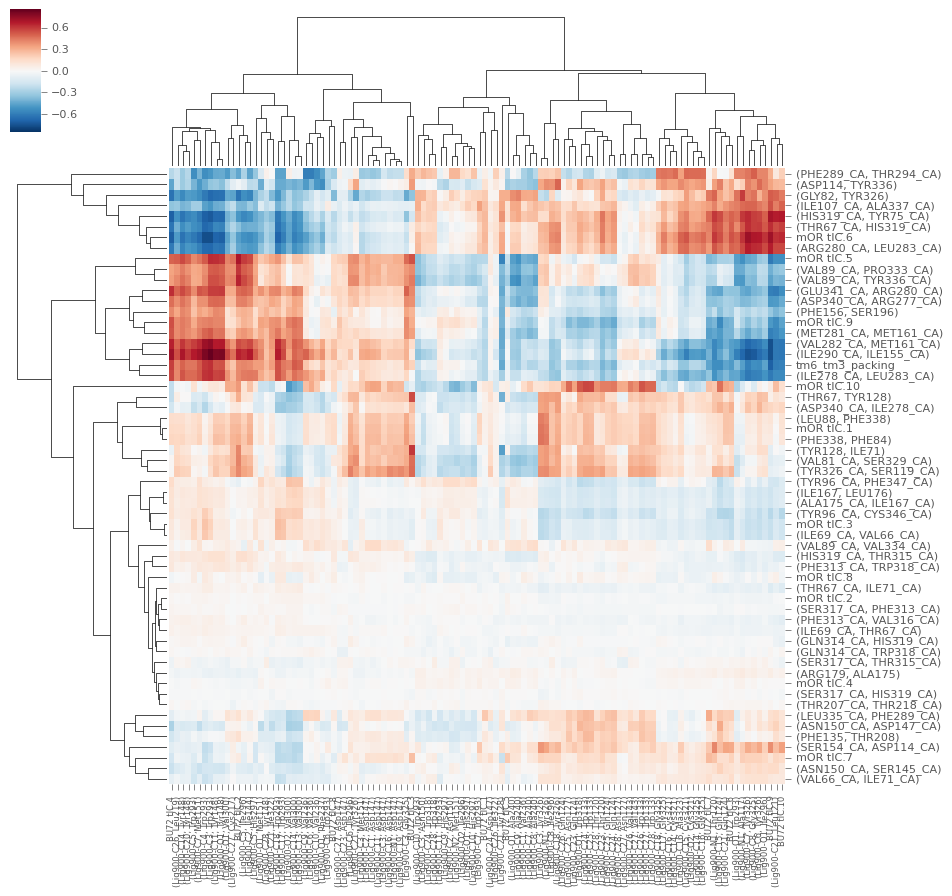

In [56]:
try:
    plt.rcParams['xtick.labelsize'] = 6.
    plt.rcParams['ytick.labelsize'] = 8.
    g = sns.clustermap(pmdf, figsize=(10,10))
    plt.show()
except:
    pass

In [57]:
plt.hexbin(features_eq["(Lig900-C4, Trp293)"], features_eq["tm6_tm3_packing"])

In [ ]:
pmdf.loc[[str(f) for f in bu72_features_eq.columns.values.tolist()]].abs().sort("correlation", ascending=False,inplace=False).iloc[:50].plot(kind='barh')

In [ ]:
import seaborn as sns
from scipy.stats import kendalltau
def hexbin(x, y, color, gridsize=25, n_colors=10, **kwargs):
    cmap = sns.light_palette(color, n_colors=n_colors, as_cmap=True)
    #cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=gridsize, cmap=cmap, **kwargs)
    
g = sns.PairGrid(features_eq[["tm6_tm3_packing", "rmsd_npxxy_inactive", "mOR tIC.4", "mOR tIC.6", "(MET281_CA, MET161_CA)", "(Lig900-C19, Gln124)", "(Lig900-C16, Val300)", "(Lig900-C8, Met151)", "(Lig900-N1, Tyr326)"]])# "(GLY82, TYR326)", "(TYR326, ASP147)", "BU72 tIC.3", "(Lig900-N1, Tyr326)", "(Lig900-C4, Tyr326)", "(Lig900-C20, Gln124)", "(Lig900-C6, Trp293)"]])
g.map_diag(plt.hist, bins=100)
#g.map_upper(sns.kdeplot, cmap="Blues_d", n_levels=10, shade=True, shade_lowest=False)
g.map_upper(plt.scatter, s=0.1, color="purple")
g.map_lower(plt.scatter, s=0.1, color="purple")

In [58]:
def custom_lim_finder(values):
    mins = np.min(values, axis=0)
    maxs = np.max(values, axis=0)
    stds = np.std(values, axis=0)
    custom_lims = [[mins[i] - 0.5*stds[i], maxs[i] + 0.5*stds[i]] for i in range(0,len(mins))]
    return custom_lims

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
#titles_i = ["tm6_tm3_packing", "mOR tIC.2"] + [str(f) for f in bu72_pp_tIC_features[1]][:5] + ["BU72 tIC.3"] + [str(f) for f in all_tIC_features[2]][:5]
titles_i = ["tm6_tm3_packing"] + ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)] + ["BU72 tIC.%d" %i for i in range(1,n_components+1)]
features_eq_vals = features_eq[titles_i].values
mins = np.min(features_eq_vals, axis=0)
maxs = np.max(features_eq_vals, axis=0)
stds = np.std(features_eq_vals, axis=0)
custom_lims = [[mins[i] - 0.5*stds[i], maxs[i] + 0.5*stds[i]] for i in range(0,len(mins))]
jointplots(features_eq_vals, analysis_dir, titles = titles_i, main = "mOR MSM", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=5., custom_lims=custom_lims, n_levels=15, worker_pool=None, parallel=True)

In [ ]:
from jointplot_d3 import *
titles_i = ["tm6_tm3_packing", "mOR tIC.2"] + [str(f) for f in bu72_pp_tIC_features[1]] + ["mOR tIC.3"] + [str(f) for f in all_tIC_features[2]]
tica_resampled = np.vstack([verboseload(bu72_pnas_resampled_file)[::1,], verboseload(apo_pnas_resampled_file)[::1,]])
mins = np.min(tica_resampled, axis=0)
maxs = np.max(tica_resampled, axis=0)
stds = np.std(tica_resampled, axis=0)
custom_lims = [[mins[i] - 1.*stds[i], maxs[i] + 1.*stds[i]] for i in range(0,len(mins))]
jointplots(features_eq[titles_i], analysis_dir, titles = titles_i, main = "mOR MSM", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=5., custom_lims=custom_lims, n_levels=15)

In [ ]:
all_tIC_features[0]

In [ ]:
"""
['bu72_reimaged_rep_100.h5', 'bu72_reimaged_rep_119.h5', 'bu72_reimaged_rep_179.h5', 'bu72_reimaged_rep_184.h5', 'bu72_reimaged_rep_186.h5', 'bu72_reimaged_rep_24.h5', 'bu72_reimaged_rep_255.h5', 'bu72_reimaged_rep_27.h5', 'bu72_reimaged_rep_56.h5', 'bu72_reimaged_rep_58.h5', 'bu72_reimaged_rep_59.h5', 'bu72_reimaged_rep_63.h5', 'bu72_reimaged_rep_64.h5', 'bu72_reimaged_rep_83.h5', 'bu72_rep_139.h5', 'bu72_rep_84.h5']"""
bu72_traj_names = [os.path.basename(t) for t in trajs if "bu72" in t]
traj_idx = bu72_traj_names.index('bu72_rep_139.h5')
f = all_traj_features[traj_idx][["tm6_tm3_packing", "(Lig900-C20, Gln124)", "(Lig900-C3, Trp293)"]]
#f = protein_ligand_msm_featurized[f.columns.values]
pd.rolling_mean(f[f.columns.values[0]], window=50).plot()

In [ ]:
pd.rolling_mean(f[f.columns.values[1]], window=50).plot()

In [ ]:
pmdf.index.values

In [ ]:
bu72_pp_pnas.T[1,:].shape

In [ ]:
from pandas.tools.plotting import scatter_matrix
#df = pd.concat([pp_features_eq, bu72_features_eq], axis=1)[["(MET281_CA, MET161_CA)", "(Lig900-N1, Tyr326)"] + [str(f) for f in bu72_pp_tIC_features[2][:2] +  all_tIC_features[2][:2]]]
df = features_eq[all_features[0]]
sm = scatter_matrix(df.iloc[::100], figsize=(6, 6), diagonal='kde')
[s.xaxis.label.set_rotation(90) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
plt.show()

In [ ]:
import seaborn as sns



g = sns.PairGrid(features_eq[all_features[0]])
g.map_upper(sns.jointplot, kind="hex", stat_func=kendalltau, color="#4CB391")
#cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
#g.map_lower(sns.kdeplot, cmap="Blues_d", n_levels=5, shade=True, shade_lowest=False)
#g.map_diag(sns.kdeplot)
#g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6)

In [59]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
keep_steps = 100000
subsample = 100
ligand_msm_featurized_traj = resample_features_by_msm_trajectory(ligand_top_features, msm_traj_index_pairs[0:keep_steps])
protein_msm_featurized_traj = resample_features_by_msm_trajectory(protein_top_features, msm_traj_index_pairs[0:keep_steps])
protein_msm_tica_traj = resample_features_by_msm_trajectory(bu72_tica_dfs, msm_traj_index_pairs[0:keep_steps])
protein_msm_pnas_traj = resample_features_by_msm_trajectory(bu72_pnas_dfs, msm_traj_index_pairs[0:keep_steps])
bu72_msm_tica_traj = resample_features_by_msm_trajectory(tica_dfs, msm_traj_index_pairs[0:keep_steps])


protein_ligand_msm_featurized = pd.concat([ligand_msm_featurized_traj*10., protein_msm_featurized_traj*10., protein_msm_tica_traj, protein_msm_pnas_traj, bu72_msm_tica_traj], axis=1)
plmf = protein_ligand_msm_featurized.iloc[::10]

In [60]:
lig_features = list(set([str(g) for l in all_tIC_features for g in l]))
prot_features = list(set([str(g) for l in bu72_pp_tIC_features for g in l]))
f0 = pd.concat([f*10. for f in ligand_top_features], axis=0)
f1 = pd.concat([f*10. for f in protein_top_features], axis=0)
f2 = pd.concat([f for f in bu72_tica_dfs])
f3 = pd.concat([f for f in bu72_pnas_dfs])
prot_lig_features = pd.concat([f0,f1,f2,f3],axis=1)
all_traj_features = [pd.concat([ligand_top_features[i]*10., protein_top_features[i]*10., bu72_tica_dfs[i], bu72_pnas_dfs[i]], axis=1) for i in range(0, len(bu72_tica_dfs))]
pm = compute_pearson_matrix(f0[lig_features].values, f1[prot_features].values)
#pmdf = pd.DataFrame(pm, columns=prot_features, index=lig_features)


In [61]:
all_traj_features_np = [f.values for f in all_traj_features]
cluster_features_averages = calculate_cluster_averages_per_feature(bu72_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features[0].columns)

tpt_paths_features = []
for tpt_path in inv_tpt_paths:
    tpt_paths_features.append(cluster_features_averages.iloc[tpt_path])

In [55]:
print(cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.) & (cluster_features_averages["(PHE156, SER196)"] > 9.5) & (cluster_features_averages["(PHE156, SER196)"] < 10.5)].index)
print(cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.) & (cluster_features_averages["(PHE156, SER196)"] > 6.) & (cluster_features_averages["(PHE156, SER196)"] < 7.)].index)

Int64Index([ 14,  26,  30,  32,  37,  43,  58,  75,  79,  86, 
            ...
            930, 938, 939, 948, 968, 978, 981, 985, 988, 993],
           dtype='int64', length=179)
Int64Index([ 11,  31,  35,  39,  42,  48,  53, 101, 110, 114, 130, 134, 135,
            161, 207, 221, 222, 237, 245, 249, 253, 260, 267, 274, 285, 290,
            294, 323, 339, 342, 359, 386, 388, 404, 409, 415, 423, 424, 457,
            466, 470, 475, 479, 494, 495, 497, 499, 517, 524, 546, 556, 569,
            580, 598, 599, 600, 612, 615, 622, 632, 649, 650, 656, 680, 686,
            687, 688, 694, 704, 711, 718, 723, 727, 729, 745, 771, 772, 775,
            779, 780, 808, 816, 824, 826, 829, 862, 868, 891, 960, 961, 967,
            971, 979, 984, 987, 989, 990, 992],
           dtype='int64')


In [89]:
print(cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] < 11.) & (cluster_features_averages["(ASP114, TYR336)"] > 8.)& (cluster_features_averages["(Lig900-C19, Ile322)"] > 5.)].index)

Int64Index([ 13,  74,  85, 112, 124, 152, 279, 356, 369, 378, 429, 432, 480,
            506, 595, 658, 662, 691, 721, 754, 846, 860, 898, 966, 977],
           dtype='int64')


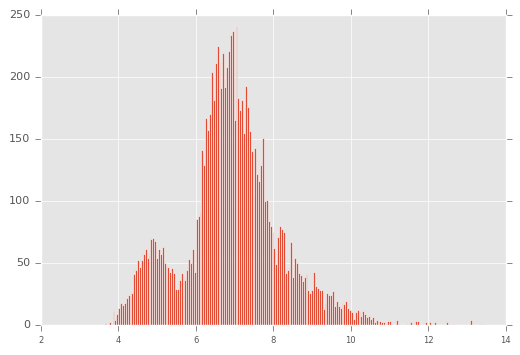

In [79]:
plt.hist(features_eq["(Lig900-N1, Tyr326)"], bins=200)
plt.show()

In [54]:
cluster_features_averages.loc[(cluster_features_averages["mOR tIC.6"] > 4.)].index

Int64Index([ 13,  74,  85, 104, 112, 152, 279, 356, 378, 429, 480, 658, 662,
            691, 754, 860, 898, 966, 977],
           dtype='int64')

In [55]:
cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] < 10.) & (cluster_features_averages["rmsd_npxxy_inactive"]<0.3)].index

Int64Index([77, 85, 132, 239, 369, 438, 480, 482, 516, 550, 726, 730, 750], dtype='int64')

In [56]:
cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 13.) & (cluster_features_averages["rmsd_npxxy_inactive"]<0.3)].index

Int64Index([  7,  36,  38,  89,  97, 114, 123, 168, 200, 223, 293, 335, 346,
            383, 431, 436, 461, 490, 498, 539, 630, 661, 727, 747, 800, 830,
            842, 855, 883, 889, 988],
           dtype='int64')

In [93]:
cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.) & (cluster_features_averages["(VAL89_CA, TYR336_CA)"] >11.5)].index

Int64Index([  7,  36,  43,  75,  89, 111, 122, 168, 200, 208, 240, 293, 299,
            302, 306, 307, 315, 346, 347, 394, 420, 431, 436, 443, 461, 472,
            490, 498, 533, 542, 630, 634, 675, 736, 747, 749, 757, 759, 785,
            800, 828, 842, 844, 855, 871, 883, 900, 950, 988],
           dtype='int64')

In [ ]:
g = sns.PairGrid(prot_lig_features[["tm6_tm3_packing", "tIC.3", "(Lig900-C20, Gln124)", "(Lig900-C3, Trp293)"]])
g.map_diag(plt.hist, bins=100)
#g.map_upper(sns.kdeplot, cmap="Blues_d", n_levels=10, shade=True, shade_lowest=False)
g.map_upper(hexbin, color="purple", n_colors=30, gridsize=30)
g.map_lower(plt.scatter, s=.1)

In [ ]:
protein_top_features[0].iloc[::3]

In [ ]:
import seaborn as sns

In [ ]:
pmdf

In [ ]:
try:
    plt.rcParams['xtick.labelsize'] = 6.
    plt.rcParams['ytick.labelsize'] = 8.
    g = sns.clustermap(pmdf, figsize=(10,10))
    plt.show()
except:
    pass

In [ ]:
prot_lig_features.plot(kind='scatter', x="(MET281_CA, MET161_CA)", y= "(Lig900-C10, Val236)")

In [ ]:
plmf.columns.values

In [62]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
if not os.path.exists("%s/rfr_r2_scores.h5" %analysis_dir):
    r2_scores, importances = compute_rf_matrix(tica_resampled, bu72_pp_tica, n_trees=500, n_folds=10)
    verbosedump(r2_scores, "%s/rfr_r2_scores.h5" %analysis_dir)
    verbosedump(importances, "%s/rfr_importances.h5" %analysis_dir)
else:
    r2_scores = verboseload("%s/rfr_r2_scores.h5" %analysis_dir)
    importances = verboseload("%s/rfr_importances.h5" %analysis_dir)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized/analysis_n_clusters1000_random/rfr_r2_scores.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt01-normalized/analysis_n_clusters1000_random/rfr_importances.h5"...


In [ ]:
r2_scores_df = pd.Series(r2_scores, index=["mOR tIC.%d" %i for i in range(1, len(r2_scores)+1)])
title = "Predicting Protein Conformation by Ligand Orientation"
r2_scores_df.plot(kind='barh', title=title)
plt.xlabel("RFR Test R^2")
plt.ylabel("Protein tIC")
plt.savefig("%s/%s.pdf" %(analysis_dir, title))

In [95]:
plt.show()

In [60]:
importances

array([[  6.03574698e-03,   1.10867352e-01,   1.64753787e-02,
          5.98877177e-02,   3.35518749e-04,   1.90953256e-03,
          5.93521898e-03,   2.50282898e-02,   2.94603034e-02,
          1.26441255e-01],
       [  1.50708643e-01,   8.11225183e-02,   2.51010558e-02,
          6.66975660e-02,   1.77101471e-01,   1.13841752e-01,
          3.16582562e-02,   9.66770020e-02,   2.86091663e-02,
          2.97462746e-01],
       [  2.44337342e-02,   1.41056246e-01,   8.73242253e-02,
          5.78862613e-02,   4.62884158e-02,   2.20126652e-01,
          9.04751652e-02,   7.32741214e-02,   2.04585867e-01,
          2.55793484e-01],
       [  3.46541085e-01,   1.73855119e-01,   2.71591849e-01,
          2.35769045e-01,   1.84146891e-01,   3.05646013e-02,
          2.63802204e-01,   9.30099447e-02,   1.07087598e-02,
          1.26427845e-02],
       [  7.69457904e-02,   9.69525062e-02,   4.25879219e-02,
          1.54086450e-01,   5.43713858e-02,   6.55090303e-02,
          1.93576525e-01

In [84]:
pearson_matrix = compute_pearson_matrix(bu72_pp_tica, tica_resampled)

'\n\nplot_clustermap(importances_df, save_file="%s/feature_importances.pdf" %(save_dir, experiment_name), method=\'average\', z_score=None)\n\n\n\nfig = plt.figure()\nax = fig.add_subplot(111)\nheatmap = ax.pcolor(np.abs(pearson_matrix), cmap=plt.cm.Blues)\n\n# put the major ticks at the middle of each cell\nax.set_xticks(np.arange(pearson_matrix.shape[0])+0.5, minor=False)\nax.set_yticks(np.arange(pearson_matrix.shape[1])+0.5, minor=False)\n\n# want a more natural, table-like display\n#ax.invert_yaxis()\n#ax.xaxis.tick_top()\n\nax.set_xticklabels(row_labels, minor=False, rotation=270)\nax.set_yticklabels(column_labels, minor=False)\nfig.subplots_adjust(bottom=0.2)\n\nfig.savefig("%s/bu72_vs_pp_pearson_heatmap.svg" % analysis_dir, format=\'svg\', dpi=1200)\nplot_file = "%s/bu72_vs_pp_pearson_heatmap.pdf" % analysis_dir\npp = PdfPages(plot_file)\n\npp.savefig(fig)\n\npp.close()  \nplt.show()\n'

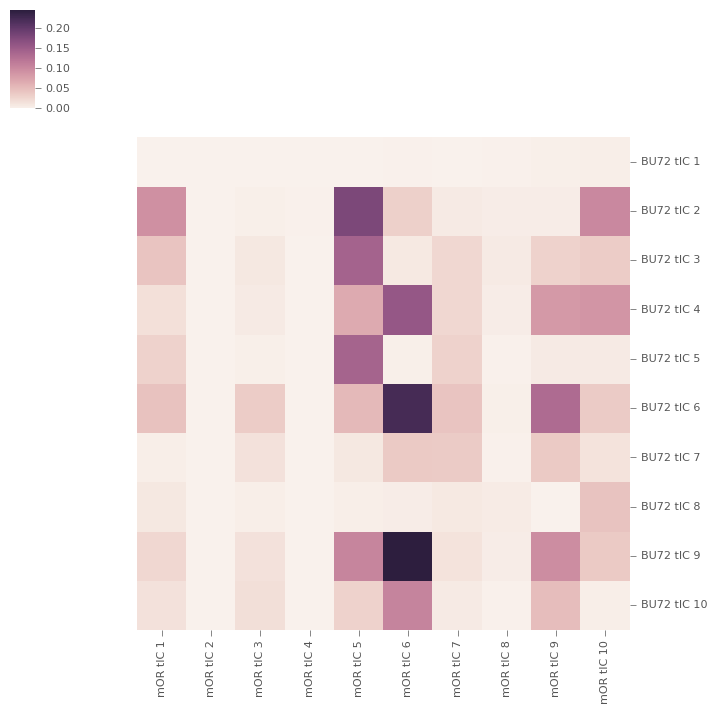

In [154]:
#import matplotlib
#matplotlib.style.use('ggplot')
#from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from plots import *
sc = StandardScaler()

#importances_scaled = pearson_matrix.T
#importances_scaled = sc.fit_transform(importances)
importances_scaled = copy.deepcopy(importances)
for j in range(0, importances_scaled.shape[1]):
    importances_scaled[:,j] *= r2_scores[j]

row_labels = ["BU72 tIC %d" %(i+1) for i in range(0,n_components)]
column_labels = ["mOR tIC %d" %(i+1) for i in range(0,pp_n_components)]

importance_df = pd.DataFrame(importances_scaled, columns=column_labels, index=row_labels)

plot_clustermap(importance_df, save_file="%s/rfr_feature_importances.pdf" %(analysis_dir), method='average', row_cluster=False, col_cluster=False, z_score=None)


"""

plot_clustermap(importances_df, save_file="%s/feature_importances.pdf" %(save_dir, experiment_name), method='average', z_score=None)



fig = plt.figure()
ax = fig.add_subplot(111)
heatmap = ax.pcolor(np.abs(pearson_matrix), cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(pearson_matrix.shape[0])+0.5, minor=False)
ax.set_yticks(np.arange(pearson_matrix.shape[1])+0.5, minor=False)

# want a more natural, table-like display
#ax.invert_yaxis()
#ax.xaxis.tick_top()

ax.set_xticklabels(row_labels, minor=False, rotation=270)
ax.set_yticklabels(column_labels, minor=False)
fig.subplots_adjust(bottom=0.2)

fig.savefig("%s/bu72_vs_pp_pearson_heatmap.svg" % analysis_dir, format='svg', dpi=1200)
plot_file = "%s/bu72_vs_pp_pearson_heatmap.pdf" % analysis_dir
pp = PdfPages(plot_file)

pp.savefig(fig)

pp.close()  
plt.show()
"""

In [155]:
r2_scores

[0.28551819410107687,
 0.0040308216445434589,
 0.11361768726117191,
 0.0057496304866600841,
 0.74225781859065587,
 0.82741036447177962,
 0.20176296879076477,
 0.03765003407061969,
 0.45335036044049809,
 0.37915352850999301]

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots(importances, plmf, top_features_per_tIC_i, top_features_per_tIC_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=3, ref_df=None, save_dir=None):
    corr_matrix = importances.T
    ori_shape = np.shape(corr_matrix)
    
    if r2s is None:
        r2s = np.max(importances, axis=0)
    
    bu72_order = np.argsort(-1.0*r2s)
    all_features = []
    if features is None:
        for k, prot_idx in enumerate(bu72_order):
            if k == n_tICs:
                break
            lig_order = np.argsort(-1.0*importances[:,prot_idx])
            #if prot_idx != 9: continue
            print(lig_order)
            for l, lig_idx in enumerate(lig_order):
                if l == n_lig_tICs:
                    break
            
                features = []

                print("mOR tIC.%d" %(k+1))
                prot_features = ["mOR tIC.%d" %(prot_idx+1)]
                if custom_features is not None:
                    prot_features += custom_features[0]
                lig_features = ["BU72 tIC.%d" %(lig_idx+1)]
                all_prot_features = [str(f) for f in top_features_per_tIC_i[prot_idx]]
                all_lig_features = [str(f) for f in top_features_per_tIC_j[lig_idx]]
                pearson_matrix = compute_pearson_matrix(plmf[all_prot_features].values, plmf[all_lig_features].values)
                pearson_shape = pearson_matrix.shape
                inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(pearson_matrix).ravel()), pearson_shape))[0]
                prot_inds = []
                lig_inds = []

                for j, ind in enumerate([idx[0] for idx in inds]):
                    if len(prot_inds) == max_features: break
                    if ind in prot_inds: continue
                    prot_features.append(str(top_features_per_tIC_i[prot_idx][ind]))
                    prot_inds.append(ind)

                if custom_features is not None:
                    features += custom_features[0]

                for j, ind in enumerate([idx[1] for idx in inds]):
                    if len(lig_inds) == max_features: break
                    if ind in lig_inds: continue
                    lig_features.append(str(top_features_per_tIC_j[lig_idx][ind]))
                    lig_inds.append(ind)

                if make_jointplots:
                    print("Creating joint deltaG plots.")
                    data_i = features_eq[prot_features+all_prot_features].values
                    print(data_i.shape)
                    data_j = features_eq[lig_features+all_lig_features].values
                    print(data_j.shape)
                    tic_save_dir = "%s/mOR_tIC%d_vs_BU72_tIC%d" %(save_dir, prot_idx+1, lig_idx+1)
                    if not os.path.exists(tic_save_dir):
                        os.makedirs(tic_save_dir)
                    #else:
                    #    continue
                    
                    
                    if ref_df is not None:
                        refcoords = ref_df[prot_features+all_prot_features].values
                        print(refcoords.shape)
                        refcoords_j = ref_df[lig_features+all_lig_features].values
                        print(refcoords_j.shape)
                    else:
                        refcoords = None
                        refcoords_j = None

                    jointplots(data_i, tic_save_dir, titles=prot_features+all_prot_features,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                               data_j=data_j, titles_j=lig_features+all_lig_features, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    
                    jointplots(data_i, tic_save_dir, titles=prot_features+all_prot_features,
                               main = "mOR MSM", refcoords=refcoords, axes=None,
                               data_j=None, titles_j=None, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    

                features += (prot_features + lig_features)
    
                #plot_df_rolling(plmf[features].iloc[::subsample], "%s/key_measurements_tIC%d.pdf" %(save_dir, prot_idx+1), True, smoothing=smoothing, include_original=False, subplots=True, min_periods=None)
                #plt.show()  
                all_features.append(features)
    #features = ["tm6_tm3_packing", "rmsd_npxxy_active"]
    #features = ["mOR tIC.1", "mOR tIC.4", "mOR tIC.5"]
    #inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(corr_matrix).ravel()), ori_shape))[0]
    return all_features

jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

all_features= make_msm_features_plots(importances, protein_ligand_msm_featurized,
                                      bu72_pp_tIC_features, all_tIC_features, n_combs=5,
                                      r2s = np.array(r2_scores), subsample=1, smoothing=100,
                                      n_tICs=5, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=jointplots_refcoords_dir)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "BU72 tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "BU72 tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(bu72_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), bu72_pp_tIC_features, all_tIC_features, n_combs=2)

[8 5 3 9 6 1 2 7 4 0]
mOR tIC.1
Creating joint deltaG plots.
(9990, 10)
(9990, 26)
(2, 10)
(2, 26)
Making delta G plots.


In [82]:
plmf = copy.deepcopy(protein_ligand_msm_featurized)
smoothing=100
names = plmf.columns.values.tolist()
for i, name in enumerate(names):
    if "Lig900" in str(name):
        names[i] = "(BU72" + name[7:]
plmf.columns = names
plot_features = plmf[["tm6_tm3_packing", "mOR tIC.5", "(MET281_CA, MET161_CA)", "(HIS319_CA, TYR75_CA)", "(BU72-C4, Tyr326)", "(BU72-N1, Tyr326)"]]
plot_df_rolling(plot_features.iloc[:100000], "%s/key_measurements_tIC5.png" %(jointplots_dir), True, smoothing=smoothing, include_original=False, subplots=True, min_periods=None)

In [177]:
tpt_paths_features

[     (Lig900-C8, Met151)  (Lig900-C27, Val143)  (Lig900-C28, Gln124)  \
 131             0.422650              0.677227              0.542569   
 898             0.416900              0.587237              0.542814   
 269             0.410534              0.612856              0.567762   
 31              0.462719              0.512456              0.556875   
 821             0.576821              0.847513              0.507091   
 
      (Lig900-O1, Lys233)  (Lig900-C16, Trp318)  (Lig900-C8, His297)  \
 131             0.532062              0.812361             0.591654   
 898             0.562122              0.826838             0.595652   
 269             0.512281              0.854304             0.577855   
 31              0.633036              0.886618             0.619693   
 821             0.869274              0.805989             0.998629   
 
      (Lig900-C7, Val300)  (Lig900-C26, Gln124)  (Lig900-C7, Val236)  \
 131             0.447995              0.739129       

In [67]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots_single(importances, plmf, top_features_per_tIC_i, top_features_per_tIC_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=1, ref_df=None, save_dir=None, prot_pairs=[],
                            tpt_paths=None):

    for t, prot_pair in enumerate(prot_pairs):
        if t == n_tICs:
            break
        if prot_pair[1] != 4: continue
        tIC_i, tIC_j = prot_pair
        tic_save_dir = "%s/tIC%d_tIC%d" %(save_dir, tIC_i+1, tIC_j+1)
        if not os.path.exists(tic_save_dir):
            os.makedirs(tic_save_dir)
        #else:
        #    continue
        
        features_i = ["mOR tIC.%d" %(tIC_i+1)] + [str(f) for f in top_features_per_tIC_i[tIC_i]]
        if custom_features is not None:
            features_i += custom_features[0]
        features_j = ["mOR tIC.%d" %(tIC_j+1)] + [str(f) for f in top_features_per_tIC_i[tIC_j]]
        
        data_i = features_eq[features_i].values
        data_j = features_eq[features_j].values

        if ref_df is not None:
            refcoords = ref_df[features_i].values
            refcoords_j = ref_df[features_j].values
        else:
            refcoords = None
            refcoords_j = None
        
        if tpt_paths is not None:
            paths_i = [p[features_i].values for p in tpt_paths]
            paths_j = [p[features_j].values for p in tpt_paths]
        
            paths_to_display = [p[features_i] for p in tpt_paths]
        else:
            paths_i = None
            paths_j = None
        
        jointplots(data_i, tic_save_dir, titles=features_i,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=features_j, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=5., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, tpt_paths=paths_i,
                           tpt_paths_j=paths_j)
                            
jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

jointplots_tpt_dir = "%s/jointplots_tpt_annotated" %analysis_dir
if not os.path.exists(jointplots_tpt_dir):
    os.makedirs(jointplots_tpt_dir)

tics_to_examine = [0, 4, 5, 8, 9]
prot_pairs = []
for i in range(0, len(tics_to_examine)):
    for j in range(i+1, len(tics_to_examine)):
        prot_pairs.append((tics_to_examine[i], tics_to_examine[j]))
print(prot_pairs)
    
make_msm_features_plots_single(importances, protein_ligand_msm_featurized,
                                      bu72_pp_tIC_features, all_tIC_features, n_combs=5,
                                      r2s = np.array(r2_scores), subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=jointplots_refcoords_dir,
                                      prot_pairs=prot_pairs,# tpt_paths=tpt_paths_features)
                                      tpt_paths=None)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "BU72 tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "BU72 tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(bu72_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), bu72_pp_tIC_features, all_tIC_features, n_combs=2)

[(0, 4), (0, 5), (0, 8), (0, 9), (4, 5), (4, 8), (4, 9), (5, 8), (5, 9), (8, 9)]
Making delta G plots.
Done plotting columns
(2, 9990)
(2, 9990)
(2, 9990)
(2, 9990)
(2, 9990)
(2, 9990)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0





Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
(-1.0, 5.0)(-1.0, 5.0)(-1.0, 5.0)(-1.0, 5.0)(-1.0, 5.0)(-1.0, 5.0)





[[ 1.17404121  0.05820045]
 [ 0.48768246  0.36926021]][[ 10.97170925   0.05820045]
 [  3.46271658   0.36926021]][[ 12.54730225   0.05820045]
 [  6.49738598   0.36926021]][[  9.15980816   0.05820045]
 [ 13.01761985   0.36926021]][[ 0.64148617  0.05820045]
 [ 0.          0.36926021]][[ 0.          0.05820045]
 [ 0.64148796  0.36926021]]





(2, 9990)(2, 9990

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se



[[  1.17404121  11.37884331]
 [  0.48768246   8.582757  ]][[ 10.97170925  11.37884331]
 [  3.46271658   8.582757  ]][[ 12.54730225  11.37884331]
 [  6.49738598   8.582757  ]][[  9.15980816  11.37884331]
 [ 13.01761985   8.582757  ]][[  0.64148617  11.37884331]
 [  0.           8.582757  ]][[  0.          11.37884331]
 [  0.64148796   8.582757  ]]





(2, 9990)(2, 9990)(2, 9990)(2, 9990)(2, 9990)(2, 9990)





Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(-1.0, 5.0)(-1.0, 5.0)(-1.0, 5.0)(-1.0, 5.0)(-1.0, 5.0)(-1.0, 5.0)





[[  1.17404121  10.684412  ]
 [  0.48768246  13.34047222]][[ 10.97170925  10.684412  ]
 [  3.46271658  13.34047222]][[ 12.54730225  10.684412  ]
 [  6.49738598  13.34047222]][[  9.15980816  10.684412  ]
 [ 13.01761985  13.34

In [ ]:
protein_ligand_msm_featurized.columns.values

In [ ]:
features_eq[all_prot_features].values

In [ ]:
features_eq.columns

In [ ]:
bu72_

In [ ]:
custom_features_4 = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "(HIS319, TYR75)", "BU72 tIC.4", "(Lig900-C7, Tyr75)", "(Lig900-C7, Trp293)"]
make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features_4, title="Key Measurements: mOR tIC.4")


In [ ]:
custom_features_2 = ["mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "BU72 tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]

make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features_2, title="Key Measurements: mOR tIC.2")




In [ ]:
print(importances)

In [ ]:
bu72_pp_tica.shape

In [83]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
coords_bounds_dict = {"tIC.6": [-2., 4.5, 7.]}
trajs_to_watch = reaction_coordinate_sampler(traj_dir, ".h5", protein_tica, 
                            ["tIC.%d" %i for i in range(1,11)], coords_bounds_dict, 
                            "%s/trajs_to_watch.csv" %pp_tica_dir)

Analyzing tIC.6
{'tIC.6': ['bu72_reimaged_rep_1.h5', 'bu72_reimaged_rep_10.h5', 'bu72_reimaged_rep_13.h5', 'bu72_reimaged_rep_14.h5', 'bu72_reimaged_rep_15.h5', 'bu72_reimaged_rep_16.h5', 'bu72_reimaged_rep_4.h5', 'bu72_reimaged_rep_8.h5', 'bu72_rep_84.h5']}

(2, 9991)(2, 9991)(2, 9991)(2, 9991)(2, 9991)




Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.




(-1.0, 5.0)(-1.0, 5.0)(-1.0, 5.0)(-1.0, 5.0)(-1.0, 5.0)




[[  9.15980816   5.39816856]
 [ 13.01761985   5.17772102]][[ 0.          5.39816856]
 [ 0.64148796  5.17772102]][[ 11.1704874    5.39816856]
 [ 10.02006531   5.17772102]][[ 0.64148617  5.39816856]
 [ 0.          5.17772102]][[ 10.684412     5.39816856]
 [ 13.34047222   5.17772102]]




[array([[  0.15831764,   4.28241382,   6.02043396,   7.29733992,
          9.47470016,   9.21337238,  1

In [ ]:
coords_bounds_dict = {"tm6_tm3_packing": [8.0, 10., 12.0, 16.0]}
trajs_to_watch = reaction_coordinate_sampler(traj_dir, ".h5",user_defined_coords, 
                            sorted(feature_name_residues_dict.keys()), coords_bounds_dict, 
                            "%s/trajs_to_watch.csv" %pp_tica_dir)
print([t for t in trajs_to_watch.values()[0] if "bu72" in t])

In [ ]:
bu72_pp_pnas.shape

In [ ]:
pearson_matrix

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
plt.clf()

import matplotlib
reload(matplotlib)
from matplotlib import pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

feature0 = []
#feature0 +=  [name for name in protein_ligand_msm_featurized.columns.values if "336" in name and "159" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tm6_tm3_packing" in name]


#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "LEU88" in name and "PHE338" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "PHE289" in name and "TYR336" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "66_C" in name and "71_C" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "npxxy_inactive" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "mOR" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "281_C" in name and "161_C" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "278_C" in name and "283_C" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "114" in name and "336" in name]

feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "BU72" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Tyr75" in name and "Lig900-C21" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Ile322" in name and "Lig900-C21" in name]

plot_df_rolling(protein_ligand_msm_featurized[feature0].iloc[::100], "%s/key_measurements_mOR_tIC4.pdf" %analysis_dir, True, smoothing=10, include_original=True, subplots=True, min_periods=None)
plt.show()

In [ ]:
plmf.columns.values

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
plt.clf()

import matplotlib
reload(matplotlib)
from matplotlib import pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

feature0 = []
#feature0 +=  [name for name in protein_ligand_msm_featurized.columns.values if "336" in name and "159" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tm6_tm3_packing" in name]


#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "LEU88" in name and "PHE338" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "PHE289" in name and "TYR336" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "66_C" in name and "71_C" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "npxxy_inactive" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "mOR" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "114" in name and "336" in name and "CA" not in name]
feature0 += ['(Phe338_Ca, Arg280_Ca)'.upper()]

feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.3" in name and "BU72" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Gln124" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-N1" in name and "Gln124" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C17" in name and "Tyr326" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C17" in name and "Leu121" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Asn150" in name]

feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "BU72" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Tyr75" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-N1" in name and "Ile298" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-O1" in name and "Cys235" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Trp293" in name]

#2    Lig900-C7-Tyr75   Lig900-C7   Tyr75      900       75    0.740407   
###   Lig900-N1-Ile298   Lig900-N1  Ile298      900      298   -0.571373   
#1 # Lig900-O1-Cys235   Lig900-O1  Cys235      900      235    0.367512   
#3   Lig900-C7-Trp293   Lig900-C7  Trp293      900      293    0.286380   


plot_df_rolling(protein_ligand_msm_featurized[feature0], "%s/key_measurements_mOR_tIC4.pdf" %analysis_dir, True, smoothing=100, include_original=True, min_periods=None)
plt.show()

In [ ]:
protein_ligand_msm_featurized.columns.values

In [ ]:
'(Phe338_Ca, Arg280_Ca)'.upper()

In [ ]:
"%s/key_measurements.pdf" %analysis_dir

In [ ]:
import plots
reload(plots)
from plots import *
bu72_pp_tica = verboseload("%s/bu72_tica_msm_lag-time10_prior-counts0.0_clusters1000_resampled_10000.h5" %pp_tica_dir)
#plot_data_vs_data(tica_resampled, bu72_pp_tica, ["BU72-BP_tIC%d" %i for i in range(1,n_components+1)], ["mOR-PP_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)
#plot_data_vs_data(bu72_pp_tica, tica_resampled, ["mOR-PP_tIC%d" %i for i in range(1,n_components+1)], ["BU72-BP_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
jointplots(bu72_pp_tica[::100,:], analysis_dir, titles = ["mOR_tIC%d" %i for i in range(1,n_components+1)], main = "mOR_vs_BU72", refcoords_file = None, axes=None, reshape=True, data_j=tica_resampled[::100,:], titles_j=["BU72_tIC%d" %i for i in range(1,n_components+1)])

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
MI_matrix = compute_MI_matrix(bu72_pp_tica, tica_resampled)

In [ ]:
print(MI_matrix[3,:])
#print(MI_matrix[:,0])
rankings = np.zeros(np.shape(MI_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = MI_matrix.shape[0] + 1. - rankdata(MI_matrix[i,:], 'min')
rankings


In [ ]:
pearson_matrix

In [ ]:
np.max(np.abs(pearson_matrix), axis=0)

In [ ]:
plt.scatter(bu72_pp_tica[:,5], tica_resampled[:,4])

In [ ]:
plt.scatter(bu72_pp_tica[:,0], bu72_pp_tica[:,5])

In [ ]:
importances

# import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

ks_matrix = compute_ks_matrix(bu72_pp_tica, tica_resampled)
ks_matrix

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

#sr_matrix = compute_sr_matrix(bu72_pp_tica, tica_resampled)
print(sr_matrix)

sr_matrix = np.abs(sr_matrix)
print(sr_matrix[0,:])
print(sr_matrix[3,:])
rankings = np.zeros(np.shape(sr_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = sr_matrix.shape[0] + 1. - rankdata(sr_matrix[i,:], 'min')
rankings



In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

rs_matrix = compute_rs_matrix(bu72_pp_tica, tica_resampled)
print(rs_matrix)

rs_matrix = np.abs(rs_matrix)
print(rs_matrix[0,:])
print(rs_matrix[3,:])
rankings = np.zeros(np.shape(rs_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = rs_matrix.shape[0] + 1. - rankdata(rs_matrix[i,:], 'min')
rankings




In [ ]:
import entropy_estimators as ee

In [ ]:
tica_coords = verboseload(projected_features_dir)
np.shape(tica_coords[0])

In [ ]:
n_samples=10
save_dir = "%s/clusters100_samples10" % tica_dir
sampling_method = "random"
clusters_map_file = "%s/clusters100_map.h5" % tica_dir
sample_clusters(clusterer_dir, projected_features_dir, traj_dir, traj_ext, save_dir, n_samples, method = sampling_method, clusters_map_file = clusters_map_file)

In [ ]:
import analysis
reload(analysis)
from analysis import *
plot_all_tics_and_clusters(tica_dir, projected_features_dir, clusterer_dir, lag_time, label = "cluster_id", active_cluster_ids = range(0,n_clusters), intermediate_cluster_ids = [], inactive_cluster_ids = [])

In [ ]:
plot_timescales(clusterer_dir, n_clusters, tica_dir, list(range(1,25)))


In [ ]:
graph_file = "%s/msm_lag_time%d_graph.graphml" % (tica_dir, lag_time)
construct_graph(msm_model_dir, clusterer_dir, n_clusters, 5, 5, graph_file, inactive = None, active = None, pnas_clusters_averages = None, tica_clusters_averages = None, docking=None, macrostate = None)


In [ ]:
from imp import reload
import custom_msm
reload(custom_msm)
from custom_msm import *
msm_file = msm_model_dir
sampled_frames_file = "%s/msm100_frames.h5" %tica_dir
msm_trajectory_filename = "%s/msm100_1000frames" %tica_dir
make_msm_trajectory(msm_file, projected_features_dir, traj_dir, sampled_frames_file, clusterer_dir, msm_trajectory_filename, 
                    n_clusters, start_cluster=22, n_steps=1000)

In [ ]:
mytraj = md.load("/home/amir/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/rep_1.h5")

In [ ]:
dir(mytraj)

In [ ]:
del mytraj

In [ ]:
subset = crystal_structure.atom_slice(range(0,400))
subset.xyz
print(subset.xyz)
distances = md.compute_contacts(subset)
print(distances)


In [ ]:
distances0 = distances[0]

In [ ]:
distances0 = np.nan_to_num(distances0)

In [ ]:
distances0

In [ ]:
np.where(distances0 > 0.0)